In [33]:
import yaml
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

In [34]:
racetrack = "/sim_ws/src/f1tenth_gym_ros/tracks/levine_closed.csv"
file = "/sim_ws/src/f1tenth_gym_ros/race_logs/race_log_pp.csv"
file2 = "/sim_ws/src/f1tenth_gym_ros/race_logs/race_log_rl_levine_sac.csv"

MAP_NAME = "levine_closed"
map_img_file = f"/sim_ws/src/f1tenth_gym_ros/maps/{MAP_NAME}.png"
map_yaml_file = f"/sim_ws/src/f1tenth_gym_ros/maps/{MAP_NAME}.yaml"

map_config = yaml.safe_load(open(map_yaml_file, 'r'))
map_resolution = map_config['resolution']
map_origin = map_config['origin']

map_img = np.array(Image.open(map_img_file).transpose(Image.FLIP_TOP_BOTTOM))
map_height, map_width = map_img.shape

race_data = pd.read_csv(file)
race_data_2 = pd.read_csv(file2)

pos_x, pos_y, lin_vel_x = race_data['pos_x'].values[::30], race_data['pos_y'].values[::30], race_data['lin_vel_x'].values[::30]
time = race_data['time'].values[::30]
pos_x_2, pos_y_2, lin_vel_x_2 = race_data_2['pos_x'].values[::5], race_data_2['pos_y'].values[::5], race_data_2['lin_vel_x'].values[::5]
time_2 = race_data_2['time'].values[::5]

optim_racedata = pd.read_csv(racetrack, header=0, names=["x", "y", "vel"])
x_optim, y_optim = optim_racedata["x"].values, optim_racedata["y"].values

In [35]:
pos_x -= map_origin[0]
pos_y -= map_origin[1]
pos_x_2 -= map_origin[0]
pos_y_2 -= map_origin[1]

pos_x /= map_resolution
pos_y /= map_resolution
pos_x_2 /= map_resolution
pos_y_2 /= map_resolution

x_optim -= map_origin[0]
y_optim -= map_origin[0]

x_optim /= map_resolution
y_optim /= map_resolution

In [39]:
start_x, start_y = pos_x[0], pos_y[0]

min_dist = np.inf
for i in range(2, len(pos_x)):
    dist = np.hypot(pos_x[i]-start_x, pos_y[i]-start_y)
    if dist < min_dist:
        min_dist = dist
        min_idx = i

lap_time = round(time[min_idx] - time[0], 3)

start_x_2, start_y_2 = pos_x_2[0], pos_y_2[0]

min_dist = np.inf
for i in range(6, len(pos_x_2)):
    dist = np.hypot(pos_x_2[i]-start_x_2, pos_y_2[i]-start_y_2)
    if dist < min_dist:
        min_dist = dist
        min_idx = i

lap_time_2 = round(time[min_idx] - time[0], 3)


In [40]:
optim_path = np.vstack((x_optim, y_optim)).T
tracked_path = np.vstack((pos_x, pos_y)).T
tracked_path_2 = np.vstack((pos_x_2, pos_y_2)).T

tree = cKDTree(optim_path)
dists, _ = tree.query(tracked_path)
dists2, _ = tree.query(tracked_path_2)

mean_error = np.mean(dists)
mean_error_2 = np.mean(dists2)


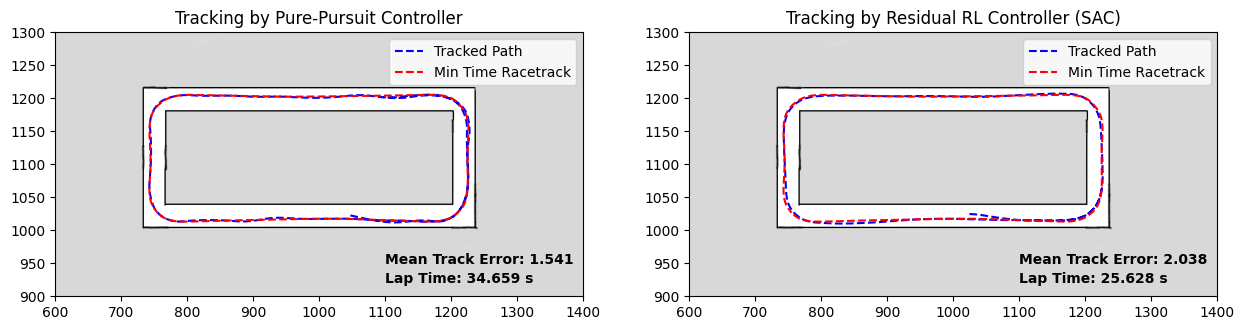

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

ax[0].imshow(map_img, cmap='gray')
ax[0].plot(pos_x, pos_y, 'b--', label="Tracked Path")
ax[0].plot(x_optim, y_optim, 'r--', label="Min Time Racetrack")
ax[0].set_xlim(600, 1400)
ax[0].set_ylim(900, 1300)
ax[0].set_title("Tracking by Pure-Pursuit Controller")
ax[0].text(x=1100, y=950, s=f"Mean Track Error: {mean_error:.3f}", fontweight='heavy')
ax[0].text(x=1100, y=920, s=f"Lap Time: {lap_time} s", fontweight='heavy')
ax[0].legend(loc='upper right')

ax[1].imshow(map_img, cmap='gray')
ax[1].plot(pos_x_2, pos_y_2, 'b--', label="Tracked Path")
ax[1].plot(x_optim, y_optim, 'r--', label="Min Time Racetrack")
ax[1].set_xlim(600, 1400)
ax[1].set_ylim(900, 1300)
ax[1].set_title("Tracking by Residual RL Controller (SAC)")
ax[1].text(x=1100, y=950, s=f"Mean Track Error: {mean_error_2:.3f}", fontweight='heavy')
ax[1].text(x=1100, y=920, s=f"Lap Time: {lap_time_2} s", fontweight='heavy')
ax[1].legend(loc='upper right')

plt.show()

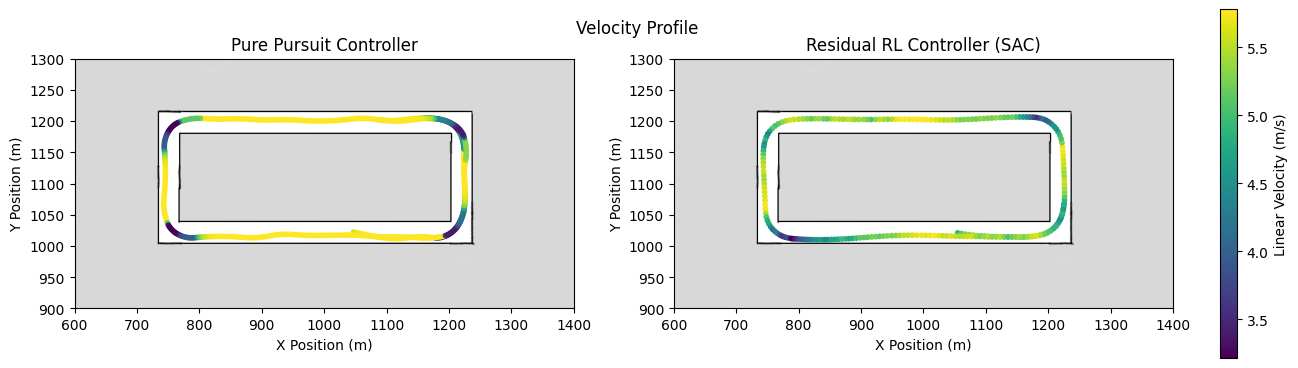

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

sc = ax[0].scatter(pos_x, pos_y, c=lin_vel_x, cmap='viridis', s=10)
ax[0].imshow(map_img, cmap='gray')
ax[0].set_xlabel("X Position (m)")
ax[0].set_ylabel("Y Position (m)")
ax[0].set_title("Pure Pursuit Controller")
ax[0].set_xlim(600, 1400)
ax[0].set_ylim(900, 1300)

sc2 = ax[1].scatter(pos_x_2[10:], pos_y_2[10:], c=lin_vel_x_2[10:], cmap='viridis', s=10)
ax[1].imshow(map_img, cmap='gray')
ax[1].set_xlabel("X Position (m)")
ax[1].set_ylabel("Y Position (m)")
ax[1].set_title("Residual RL Controller (SAC)")
ax[1].set_xlim(600, 1400)
ax[1].set_ylim(900, 1300)

cbar = fig.colorbar(sc2, ax=ax, orientation='vertical', fraction=0.015, pad=0.04)
cbar.set_label("Linear Velocity (m/s)")
plt.suptitle("Velocity Profile", y=0.7)
plt.show()

In [48]:
file3 = "/sim_ws/src/f1tenth_gym_ros/race_logs/race_log_rl_levine_ppo.csv"

race_data_3 = pd.read_csv(file3)

pos_x_3, pos_y_3, lin_vel_x_3 = race_data_3['pos_x'].values[::5], race_data_3['pos_y'].values[::5], race_data_3['lin_vel_x'].values[::5]
time_3 = race_data_3['time'].values[::5]


pos_x_3 -= map_origin[0]
pos_y_3 -= map_origin[1]

pos_x_3 /= map_resolution
pos_y_3 /= map_resolution

start_x_3, start_y_3 = pos_x_3[0], pos_y_3[0]

min_dist = np.inf
for i in range(6, len(pos_x_3)):
    dist = np.hypot(pos_x_3[i]-start_x_3, pos_y_3[i]-start_y_3)
    if dist < min_dist:
        min_dist = dist
        min_idx = i

lap_time_3 = round(time[min_idx] - time[0], 3)

tracked_path_3 = np.vstack((pos_x_3, pos_y_3)).T
dists3, _ = tree.query(tracked_path_3)
mean_error_3 = np.mean(dists3)

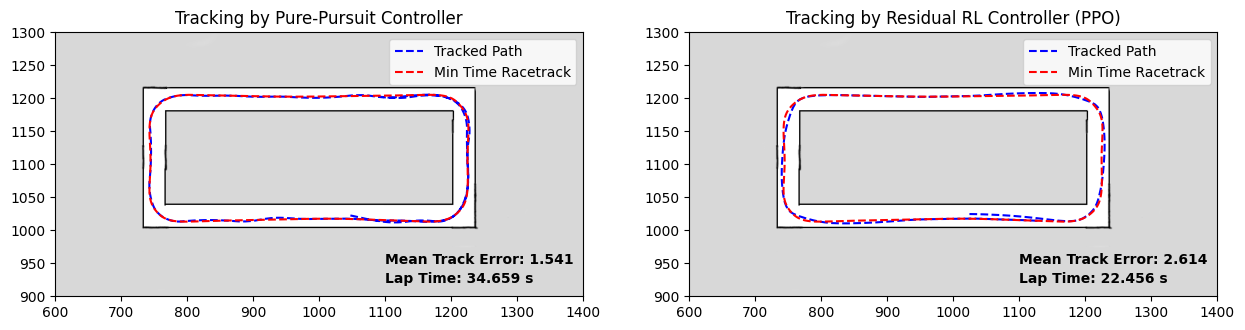

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

ax[0].imshow(map_img, cmap='gray')
ax[0].plot(pos_x, pos_y, 'b--', label="Tracked Path")
ax[0].plot(x_optim, y_optim, 'r--', label="Min Time Racetrack")
ax[0].set_xlim(600, 1400)
ax[0].set_ylim(900, 1300)
ax[0].set_title("Tracking by Pure-Pursuit Controller")
ax[0].text(x=1100, y=950, s=f"Mean Track Error: {mean_error:.3f}", fontweight='heavy')
ax[0].text(x=1100, y=920, s=f"Lap Time: {lap_time} s", fontweight='heavy')
ax[0].legend(loc='upper right')

ax[1].imshow(map_img, cmap='gray')
ax[1].plot(pos_x_3, pos_y_3, 'b--', label="Tracked Path")
ax[1].plot(x_optim, y_optim, 'r--', label="Min Time Racetrack")
ax[1].set_xlim(600, 1400)
ax[1].set_ylim(900, 1300)
ax[1].set_title("Tracking by Residual RL Controller (PPO)")
ax[1].text(x=1100, y=950, s=f"Mean Track Error: {mean_error_3:.3f}", fontweight='heavy')
ax[1].text(x=1100, y=920, s=f"Lap Time: {lap_time_3} s", fontweight='heavy')
ax[1].legend(loc='upper right')

plt.show()

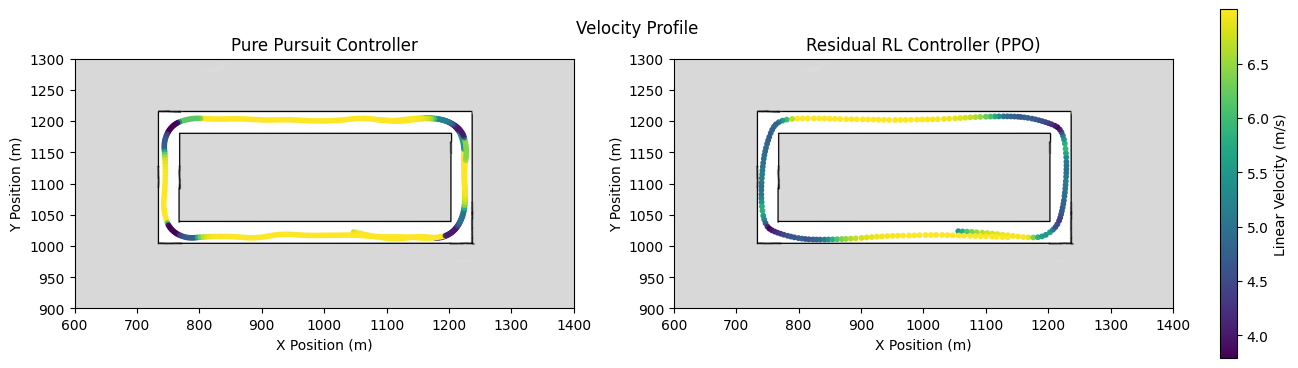

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

sc = ax[0].scatter(pos_x, pos_y, c=lin_vel_x, cmap='viridis', s=10)
ax[0].imshow(map_img, cmap='gray')
ax[0].set_xlabel("X Position (m)")
ax[0].set_ylabel("Y Position (m)")
ax[0].set_title("Pure Pursuit Controller")
ax[0].set_xlim(600, 1400)
ax[0].set_ylim(900, 1300)

sc2 = ax[1].scatter(pos_x_3[10:], pos_y_3[10:], c=lin_vel_x_3[10:], cmap='viridis', s=10)
ax[1].imshow(map_img, cmap='gray')
ax[1].set_xlabel("X Position (m)")
ax[1].set_ylabel("Y Position (m)")
ax[1].set_title("Residual RL Controller (PPO)")
ax[1].set_xlim(600, 1400)
ax[1].set_ylim(900, 1300)

cbar = fig.colorbar(sc2, ax=ax, orientation='vertical', fraction=0.015, pad=0.04)
cbar.set_label("Linear Velocity (m/s)")
plt.suptitle("Velocity Profile", y=0.7)
plt.show()